# MFM simulations

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


### Importing Packages

In [6]:
%matplotlib notebook
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import random
import matplotlib.pyplot as plt

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [7]:
region = df.Region(p1=(0, 0, 0), p2=(150e-9, 150e-9, 150e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='skl2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

In [8]:
Ms = 384e3

    
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero above the sample,
    Ms inside sample.

    Sample thickness is 50nm.

    """
    x, y, z = pos
    if (z < 50e-9):
        return Ms
    else:
        return 0
    
def m_t_q(pos):
    """
    Function to make a tripple q structure with a period of 50 nm
    
    """
    q = 2*np.pi/(50e-9)
    x, y, z = pos
    
    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

<IPython.core.display.Javascript object>


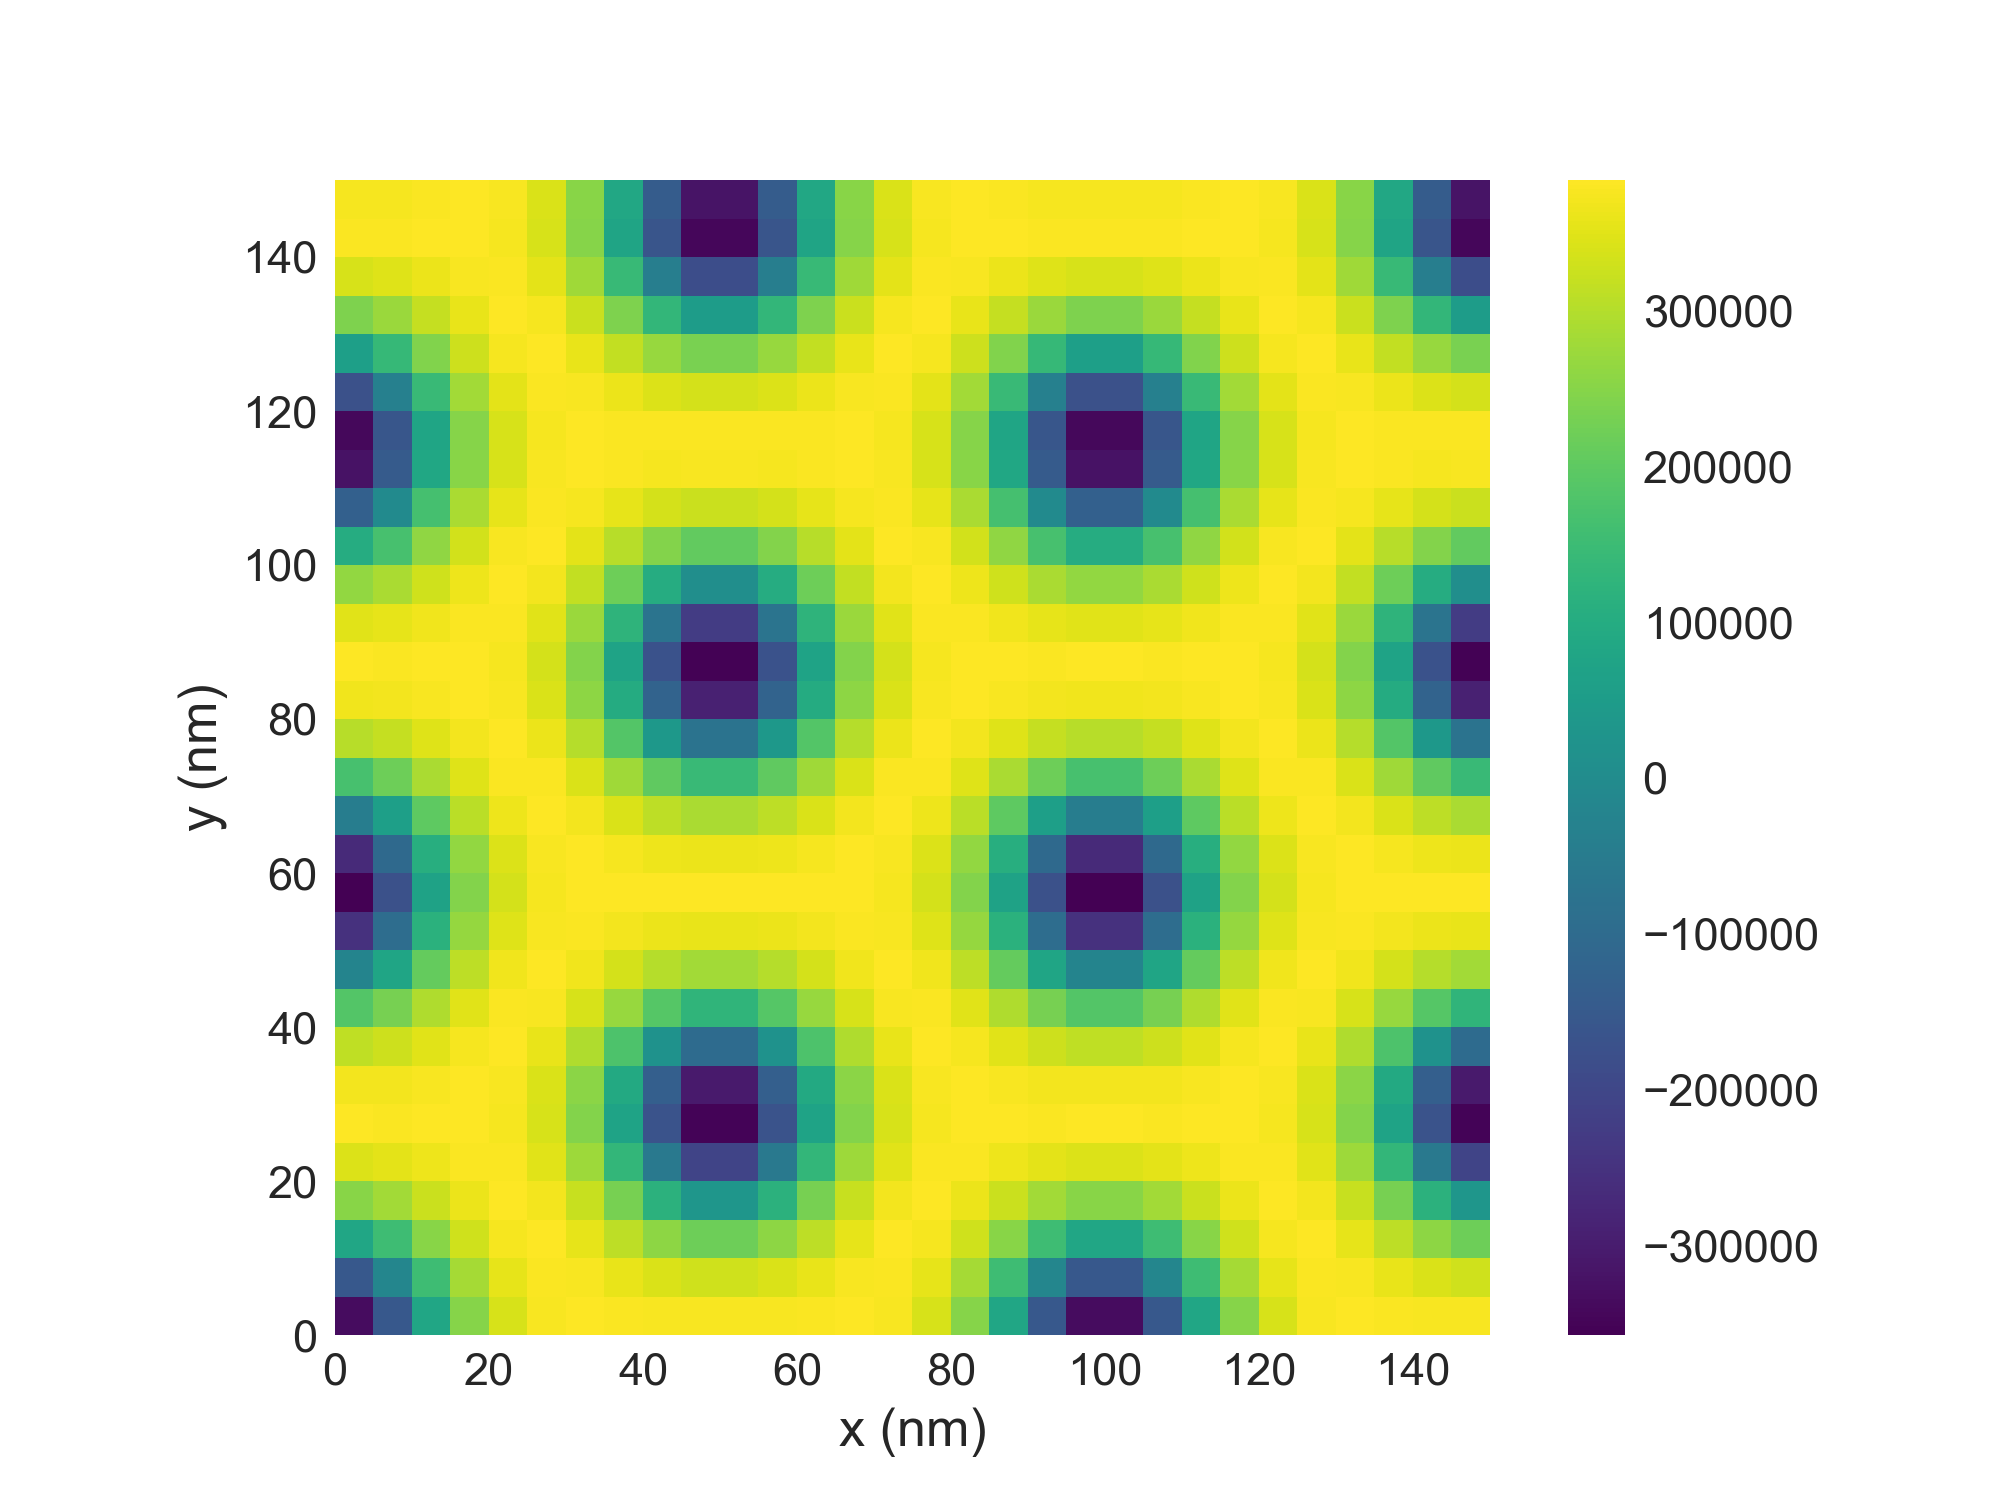

In [9]:
system.m = df.Field(mesh, dim=3, value=m_t_q, norm=Ms_fun)
system.m.z.plane(z=5e-9).mpl()

<IPython.core.display.Javascript object>


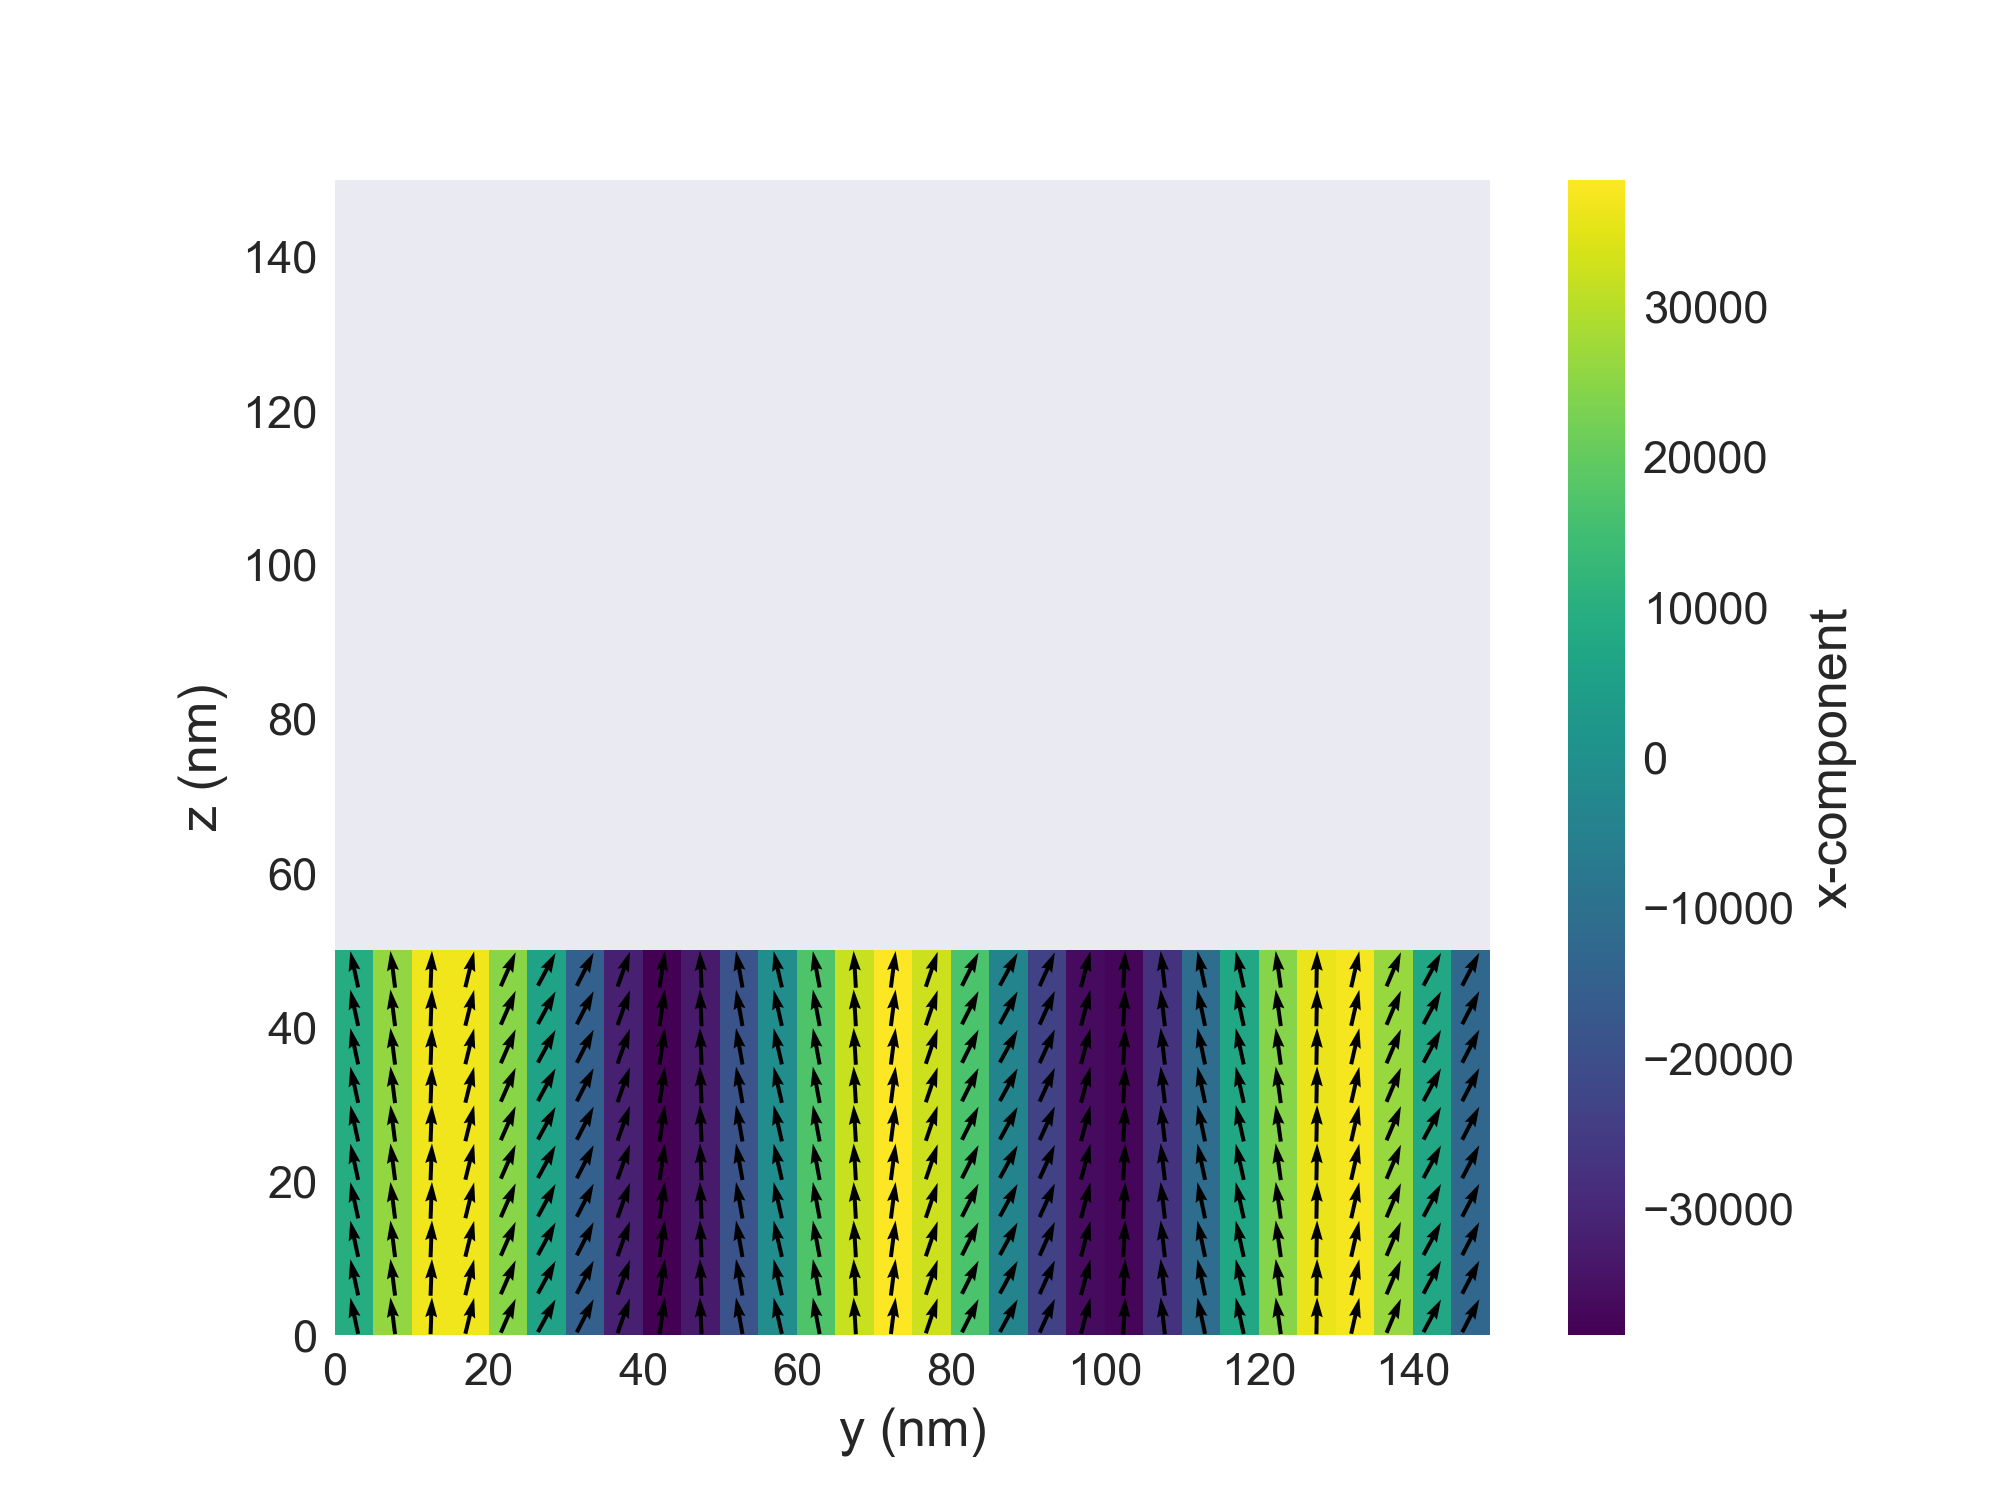

In [10]:
system.m.plane('x').mpl()

In [11]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/08 13:15]... (63.8 s)


<IPython.core.display.Javascript object>


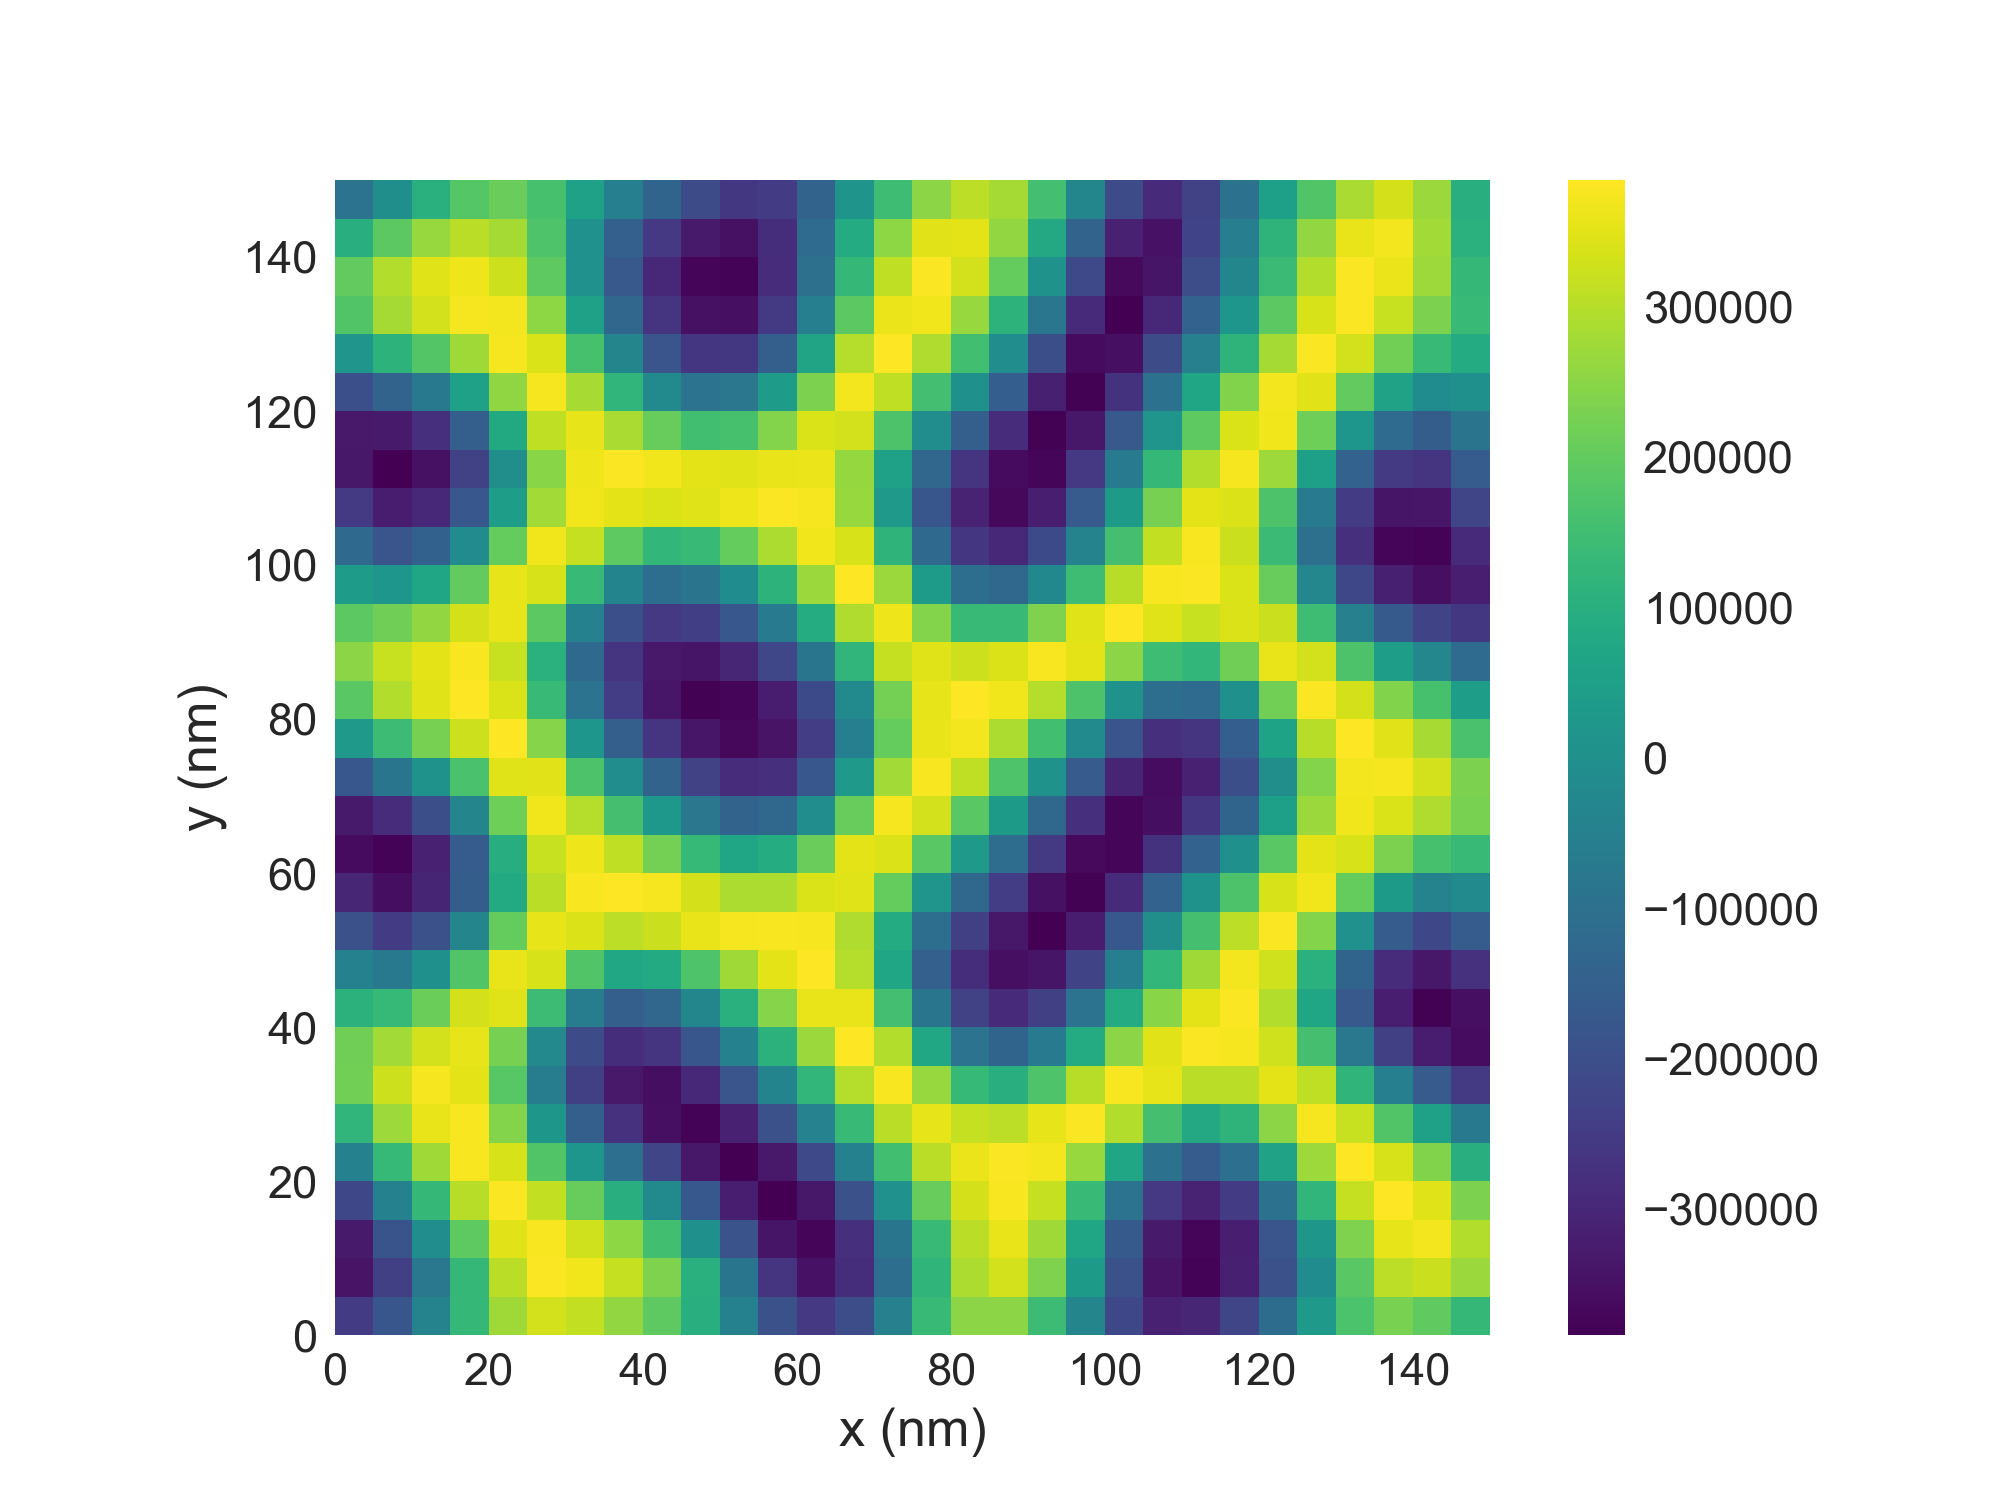

In [12]:
system.m.z.plane(z=5e-9).mpl()

### Stray field

Calculate stray field (does this give the stray field when an external field is also applied?)

In [29]:
stray_field = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (DockerOOMMFRunner) [2021/07/08 13:22]... (3.9 s)


In [30]:
div1 = stray_field.derivative('z', n=1)
div2 = stray_field.derivative('z', n=2)

In [31]:
div1.z

Field(mesh=Mesh(region=Region(p1=(0.0, 0.0, 0.0), p2=(1.5e-07, 1.5e-07, 1.5e-07)), n=(30, 30, 30), bc='', subregions={}), dim=1)

In [32]:
Q = 650.0
k = 4.0

tip_q = 1e-6
tip_m_x = 0# 1e-13
tip_m_y = 0
tip_m_z = 0#1e-13

phase_shift = (Q*1.256e-6/k)*(tip_q*div1.z+tip_m_x*div2.x+tip_m_y*div2.y+tip_m_z*div2.z)

<IPython.core.display.Javascript object>


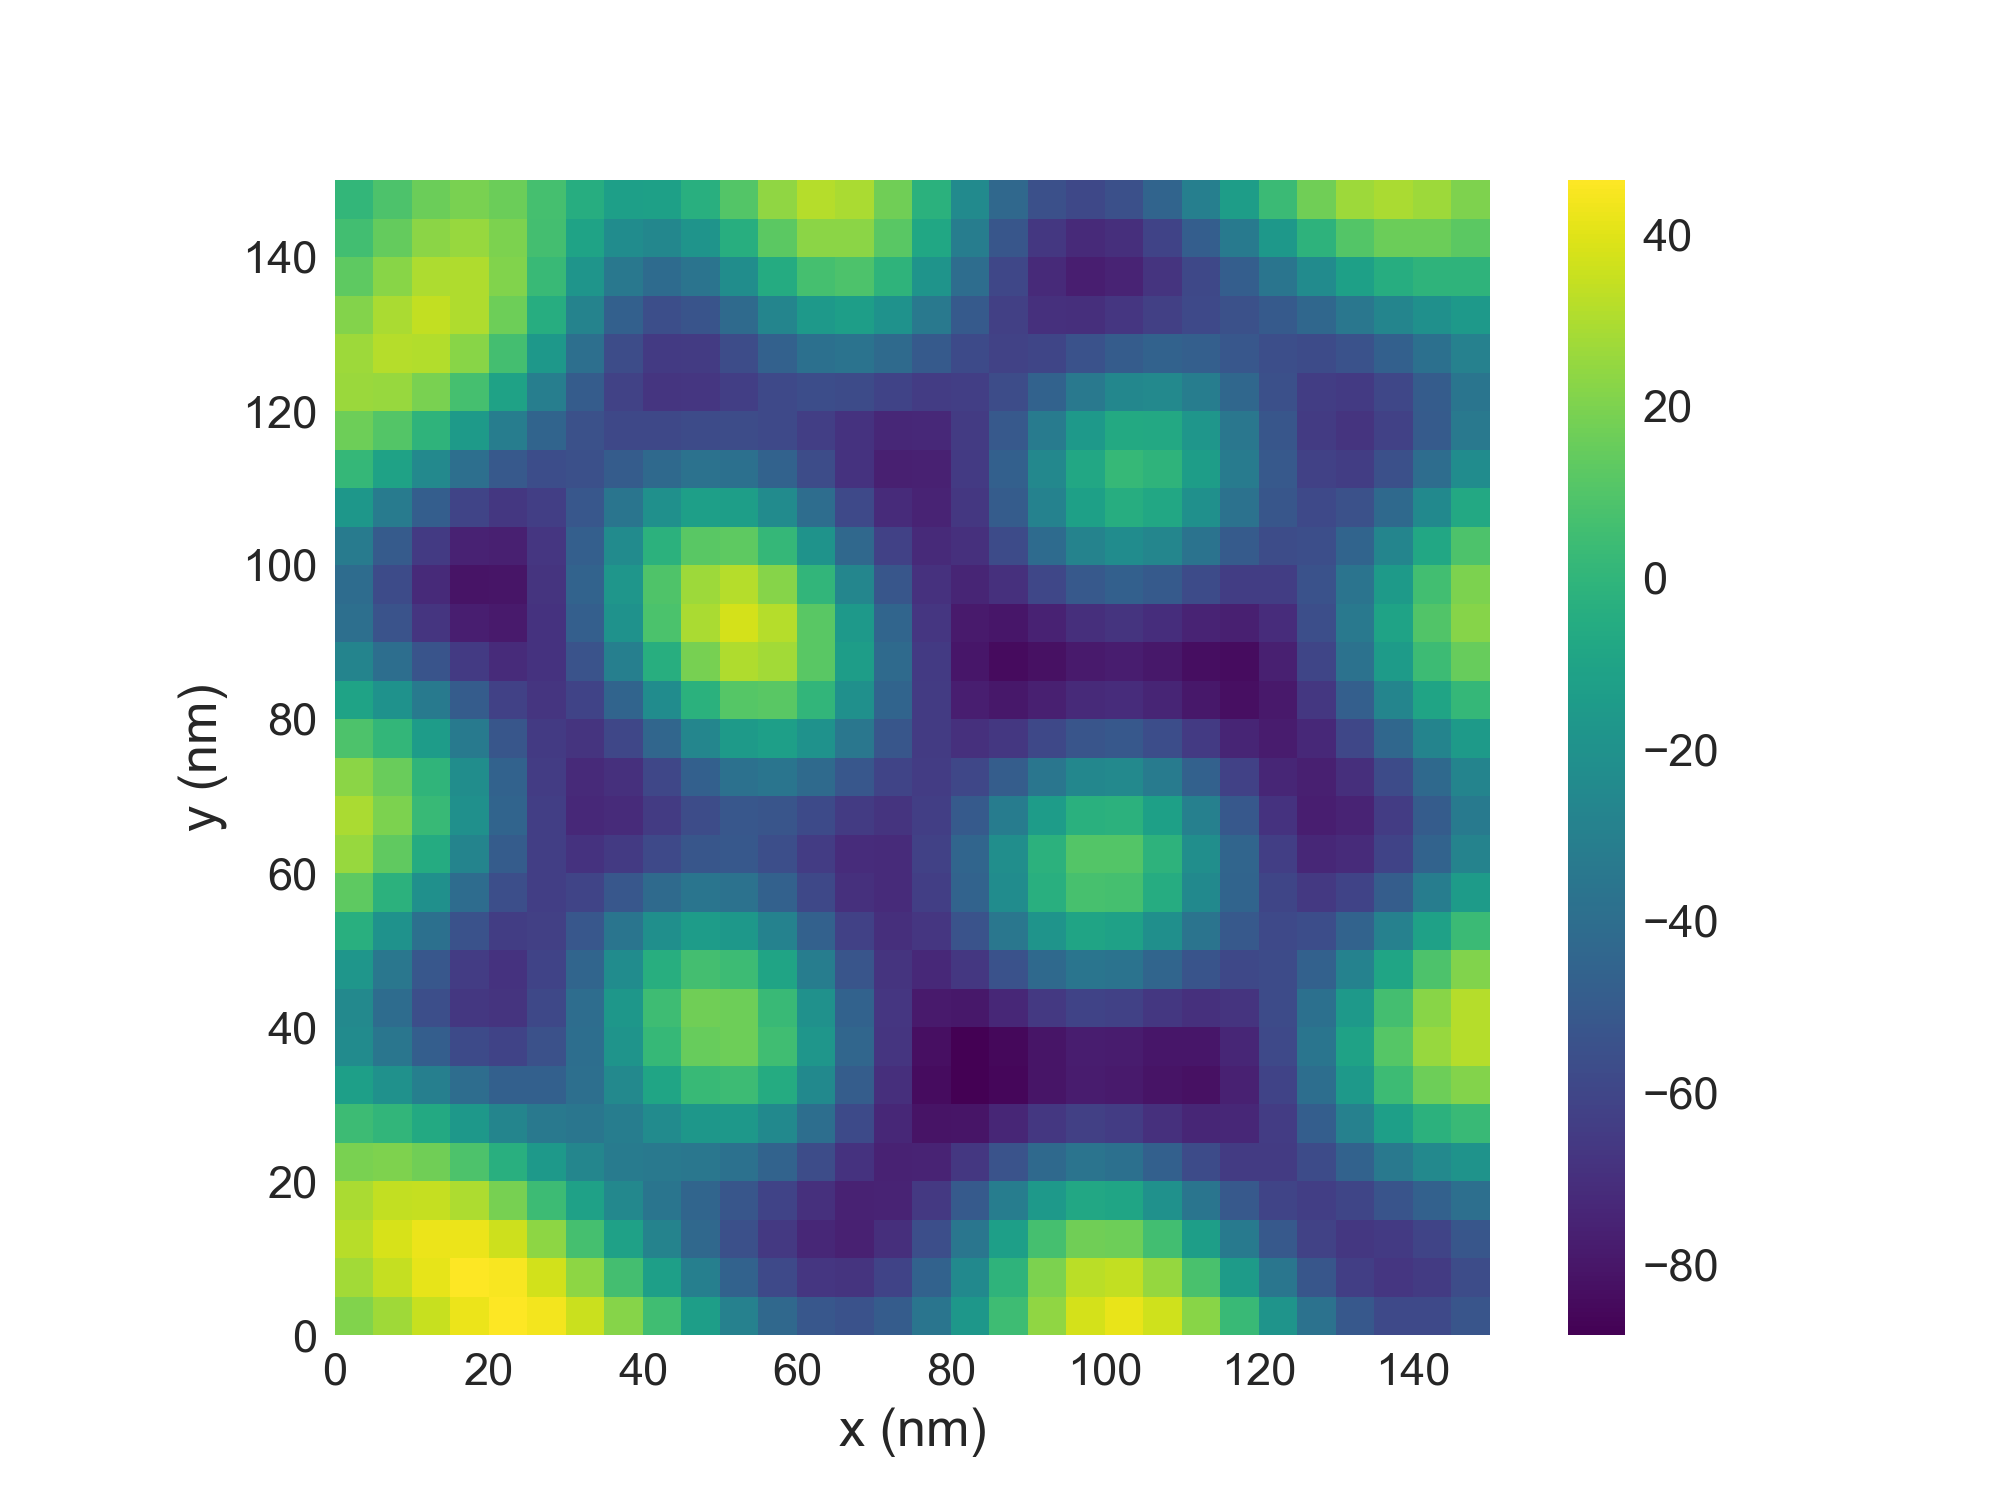

In [34]:
phase_shift.plane(z=80e-9).mpl_scalar()

Try making MFM function

In [40]:
def mfm_phase(system, Q=650, k=4, tip_q=1e-6, tip_m=(0,0,1e-13)):
    stray_field = oc.compute(system.energy.demag.effective_field, system)
    dh_dz = stray_field.derivative('z', n=1)
    d2h_dz2 = stray_field.derivative('z', n=2)
    return (Q*1.256e-6/k)*(tip_q*div1.z+tip_m_x*div2.x+tip_m_y*div2.y+tip_m_z*div2.z)

In [36]:
phase = mfm_phase(system, Q=650, k=4, tip_q=1e-6, tip_m=(0,0,1e-13))

Running OOMMF (DockerOOMMFRunner) [2021/07/08 13:28]... (4.2 s)


<IPython.core.display.Javascript object>


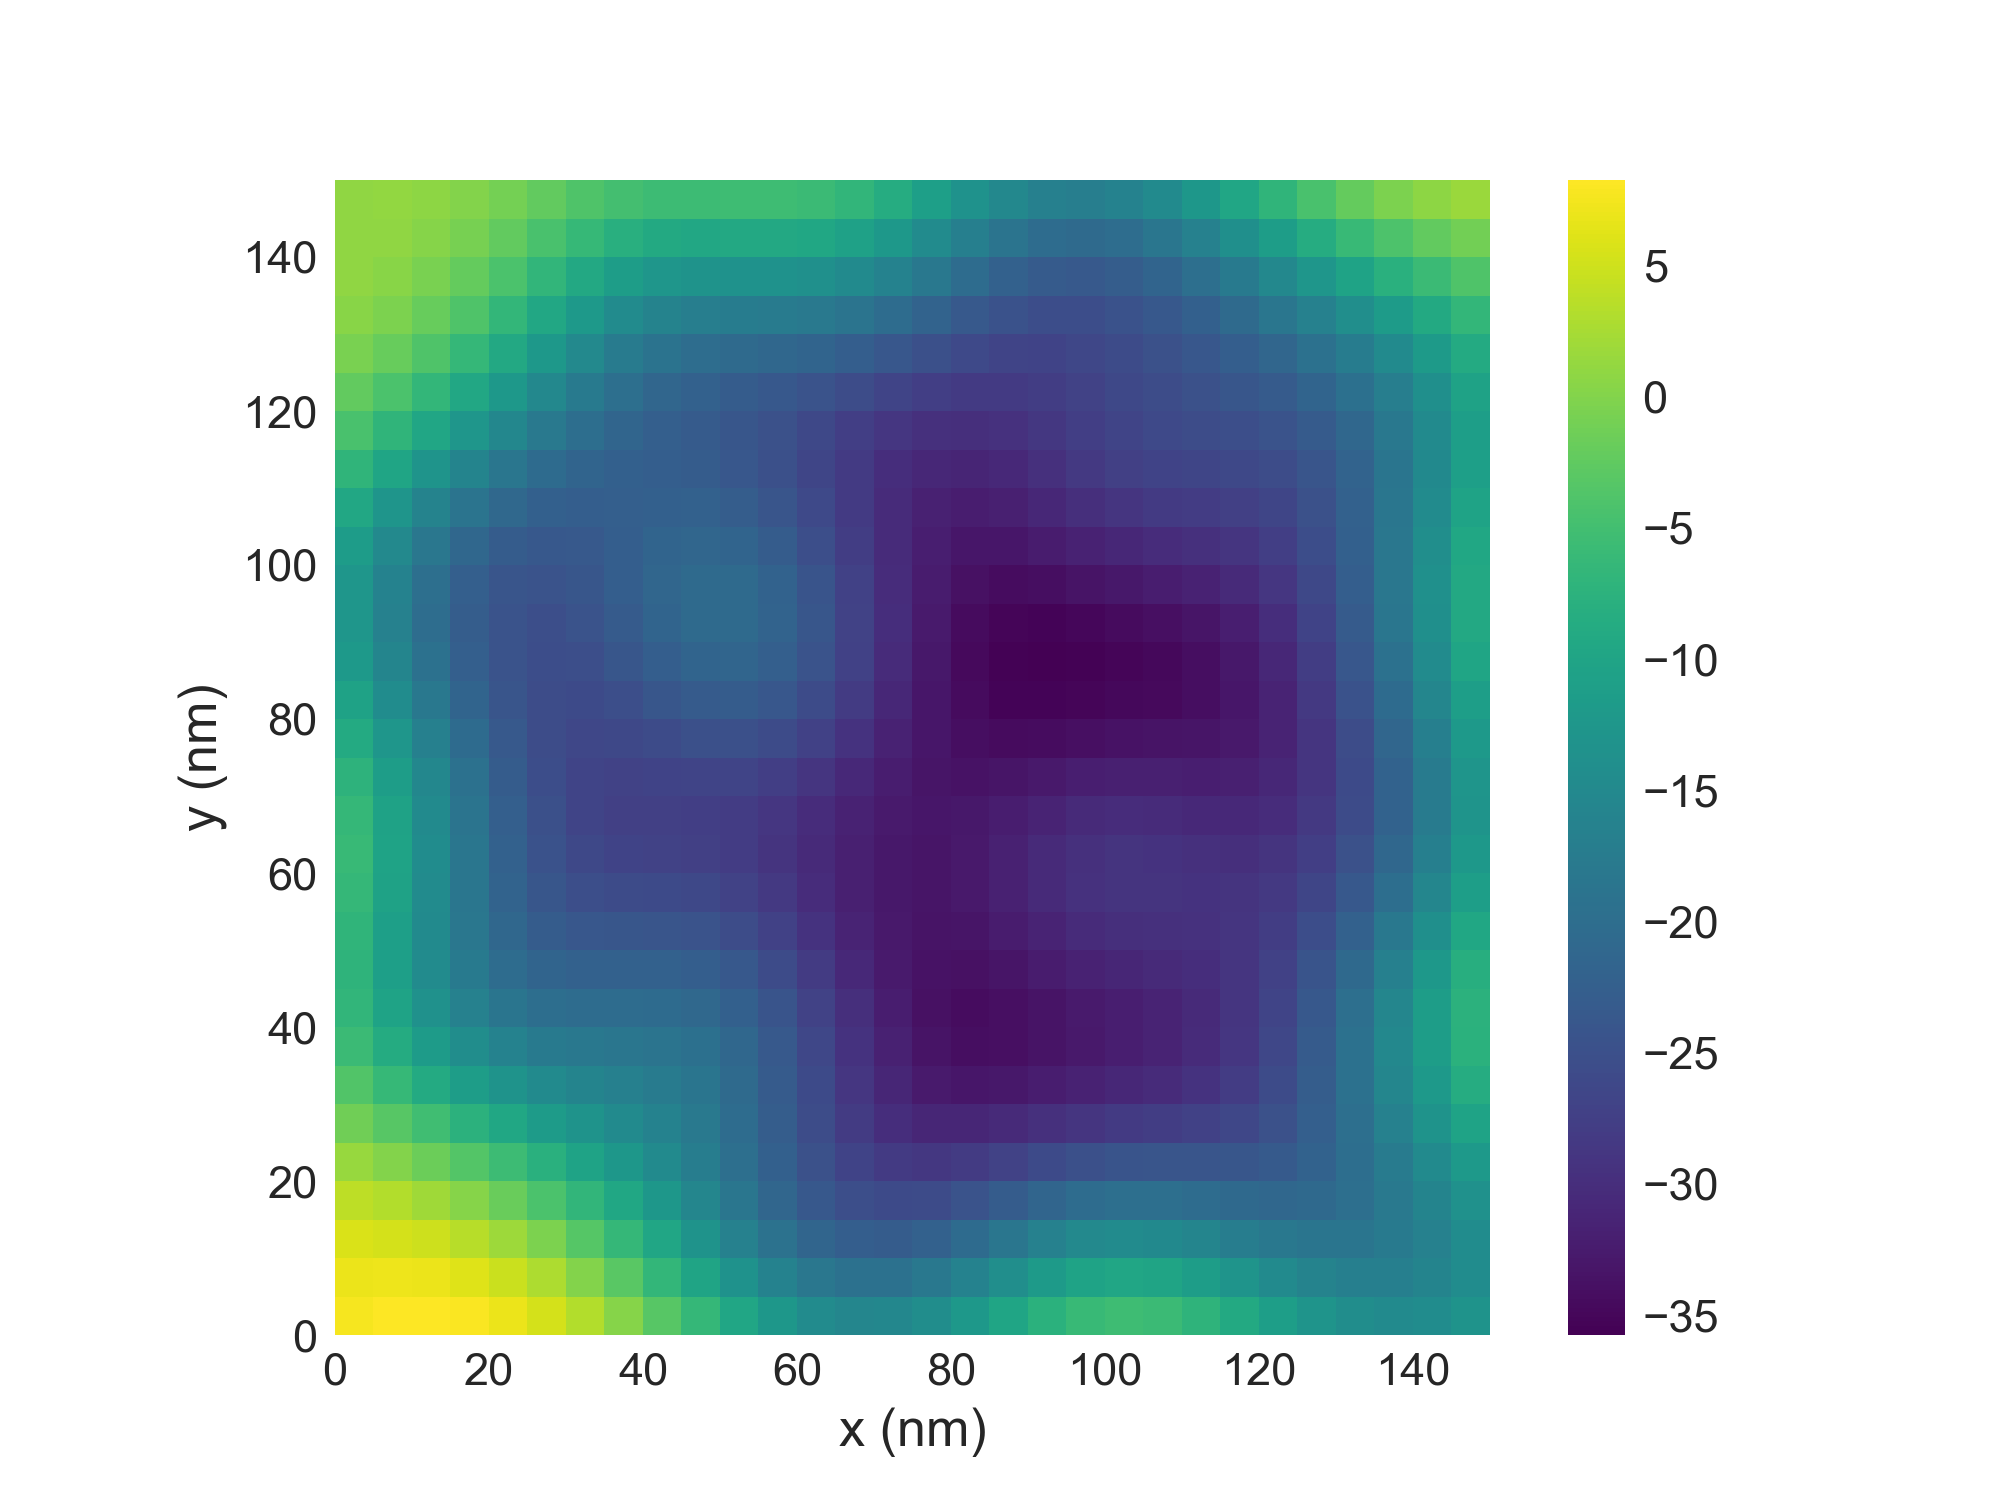

In [41]:
phase.plane(z=100e-9).mpl_scalar()